# Dimension 4 Experiment: Convergence, Computation Time, and Absolute Error Analysis

**Overview:**  
In this notebook we analyze the performance of the adapted Wasserstein distance computation in a 4-dimensional setting.  

**Experiment Details:**  
- **Matrices for Process X and Measure "mu":**

  $$
  L = \begin{pmatrix}
  1 & 0 & 0 & 0 \\
  1 & 2 & 0 & 0 \\
  1 & 2 & 3 & 0 \\
  1 & 2 & 3 & 4 
  \end{pmatrix}
  $$

- **Matrices for Process Y and Measure "nu":**

  $$
  M = \begin{pmatrix}
  1 & 0 & 0 & 0 \\
  2 & 1 & 0 & 0 \\
  3 & 2 & 1 & 0 \\
  4 & 3 & 2 & 1 
  \end{pmatrix}
  $$

- **Fixed Grid Size:** 0.01  
- **Sample Sizes:** [2000, 4000, 6000, 10000]  
- **Runs per Sample Size:** 10 (each run uses two different random seeds, one for each matrix)

**Procedure:**  
1. For each sample size, generate sample paths for X (using **L**) and Y (using **M**) with different random seeds.  
2. Compute the theoretical benchmark using `adapted_wasserstein_squared` (which depends only on **L** and **M**).  
3. Convert the generated paths into their adapted versions using `path2adaptedpath` with the fixed grid.  
4. Build a common quantization map and convert the adapted paths into indexed paths, then sort them and build conditional distributions.  
5. Compute the numerical adapted Wasserstein squared distance using `nested2_parallel` (with 30 processes) and record the elapsed time.

**Outputs:**  
- Raw results printed to the console  
- Three plots:
   - **Distance Convergence:** Mean adapted Wasserstein squared distance (± std) vs. sample size (benchmark shown)  
   - **Computation Time:** Mean computation time (± std) vs. sample size  
   - **Absolute Error:** Mean absolute error (± std) between the computed mean and benchmark vs. sample size


In [8]:
import os, sys, numpy as np, time, random
import matplotlib.pyplot as plt

# Set up the source path (adjust as needed for your project)
notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import your custom functions (ensure these are accessible in your PYTHONPATH)
from optimal_code.utils import *
from optimal_code.optimal_solver import *
from adapted_empirical_measure.AEM_grid import *

In [9]:
sample_sizes = [2000, 4000, 6000, 10000]
fixed_grid = 0.07
n_runs = 10

# Define matrices (dimension 4)
L = np.array([[1, 0, 0, 0],
              [1, 2, 0, 0],
              [1, 2, 3, 0],
              [1, 2, 3, 4]])
M = np.array([[1, 0, 0, 0],
              [2, 1, 0, 0],
              [3, 2, 1, 0],
              [4, 3, 2, 1]])


In [13]:
results = {}  # Dictionary to store results keyed by sample size

for n_sample in sample_sizes:
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    
    for run in range(n_runs):
        # Generate two different random seeds (one for each matrix)
        seed1 = np.random.randint(10000)
        #seed2 = np.random.randint(10000)
        #while seed2 == seed1:  # Ensure they are different
            #seed2 = np.random.randint(10000)
        
        # Generate sample paths:
        # Process X (using matrix L) with seed1
        X, A = Lmatrix2paths(L, n_sample, seed=seed1, verbose=False)
        # Process Y (using matrix M) with seed2
        Y, B = Lmatrix2paths(M, n_sample, seed=seed1, verbose=False)
        
        # Compute the theoretical benchmark distance
        benchmark = adapted_wasserstein_squared(A, B)
        
        # Convert paths to adapted versions using the fixed grid
        adaptedX = path2adaptedpath(X, delta_n=fixed_grid)
        adaptedY = path2adaptedpath(Y, delta_n=fixed_grid)
        
        # Build quantization mapping
        q2v = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
        v2q = {k: v for v, k in enumerate(q2v)}
        
        # Quantize paths using the mapping
        qX = np.array([[v2q[x] for x in y] for y in adaptedX])
        qY = np.array([[v2q[x] for x in y] for y in adaptedY])
        
        # Sort the quantized paths (transposing to match the expected shape)
        qX = sort_qpath(qX.T)
        qY = sort_qpath(qY.T)
        
        # Build conditional distributions
        mu_x = qpath2mu_x(qX)
        nu_y = qpath2mu_x(qY)
        mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn = list_repr_mu_x(mu_x, q2v)
        nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn = list_repr_mu_x(nu_y, q2v)
        
        # Compute the numerical adapted Wasserstein squared distance and record computation time
        t_start = time.perf_counter()
        AW_2square = nested2_parallel(mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn,
                                      nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn,
                                      n_processes=42)
        elapsed = time.perf_counter() - t_start
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Sample size {n_sample}, Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f} s")
    
    # Store the results for the current sample size
    results[n_sample] = {"distances": distances_runs,
                         "times": times_runs,
                         "benchmark": benchmark}


Running experiments for sample size: 2000


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 99.90it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 442.06it/s]


Sample size 2000, Run 1: AW_2^2 = 27.7351, Time = 6.8932 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 427.34it/s]


Sample size 2000, Run 2: AW_2^2 = 27.0590, Time = 7.1761 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 425.00it/s]


Sample size 2000, Run 3: AW_2^2 = 25.9911, Time = 6.9734 s


 69%|█████████████████████████████▌             | 33/48 [00:00<00:00, 99.61it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 632.82it/s]


Sample size 2000, Run 4: AW_2^2 = 27.3014, Time = 7.1197 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 586.37it/s]


Sample size 2000, Run 5: AW_2^2 = 27.7439, Time = 7.0833 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 401.37it/s]


Sample size 2000, Run 6: AW_2^2 = 26.9148, Time = 6.9528 s


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 98.20it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 95.75it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 93.57it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 93.95it/s]

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 404.93it/s]


Sample size 2000, Run 7: AW_2^2 = 26.4902, Time = 7.2396 s


100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 65.20it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 532.75it/s]


Sample size 2000, Run 8: AW_2^2 = 26.9488, Time = 7.0720 s


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 93.71it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 97.31it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 280.35it/s]


Sample size 2000, Run 9: AW_2^2 = 26.5280, Time = 7.0640 s


100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 99.48it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 618.36it/s]


Sample size 2000, Run 10: AW_2^2 = 28.0038, Time = 7.1814 s

Running experiments for sample size: 4000


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 381.93it/s]


Sample size 4000, Run 1: AW_2^2 = 27.6816, Time = 17.7051 s


 85%|████████████████████████████████████▋      | 81/95 [00:01<00:00, 46.75it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 265.24it/s]


Sample size 4000, Run 2: AW_2^2 = 27.0316, Time = 17.5199 s


 55%|███████████████████████▌                   | 52/95 [00:01<00:00, 46.83it/s]

100%|███████████████████████████████████████████| 95/95 [00:01<00:00, 50.80it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 412.38it/s]


Sample size 4000, Run 3: AW_2^2 = 28.2207, Time = 17.9225 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 360.52it/s]


Sample size 4000, Run 4: AW_2^2 = 27.3997, Time = 18.2766 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 563.30it/s]


Sample size 4000, Run 5: AW_2^2 = 27.9223, Time = 18.0753 s


100%|███████████████████████████████████████████| 69/69 [00:02<00:00, 29.17it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 364.60it/s]


Sample size 4000, Run 6: AW_2^2 = 28.3056, Time = 18.4980 s


 34%|██████████████▍                            | 32/95 [00:00<00:01, 43.22it/s]

100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 46.86it/s]

100%|███████████████████████████████████████████| 67/67 [00:02<00:00, 23.96it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 552.17it/s]


Sample size 4000, Run 7: AW_2^2 = 28.2102, Time = 17.9809 s


100%|███████████████████████████████████████████| 95/95 [00:01<00:00, 49.96it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 559.39it/s]


Sample size 4000, Run 8: AW_2^2 = 27.3107, Time = 17.7309 s


100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 46.60it/s]

100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 46.83it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 395.39it/s]


Sample size 4000, Run 9: AW_2^2 = 28.2152, Time = 18.1812 s


 82%|███████████████████████████████████▎       | 78/95 [00:01<00:00, 47.30it/s]

100%|███████████████████████████████████████████| 68/68 [00:03<00:00, 22.07it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 357.72it/s]


Sample size 4000, Run 10: AW_2^2 = 28.1307, Time = 18.3534 s

Running experiments for sample size: 6000


100%|█████████████████████████████████████████| 143/143 [00:04<00:00, 32.36it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 514.26it/s]


Sample size 6000, Run 1: AW_2^2 = 27.7853, Time = 33.3290 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 268.99it/s]


Sample size 6000, Run 2: AW_2^2 = 28.1918, Time = 34.1149 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 357.66it/s]


Sample size 6000, Run 3: AW_2^2 = 28.1936, Time = 37.9183 s


100%|█████████████████████████████████████████| 142/142 [00:04<00:00, 32.12it/s]

100%|███████████████████████████████████████████| 89/89 [00:05<00:00, 17.50it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 529.05it/s]


Sample size 6000, Run 4: AW_2^2 = 28.4296, Time = 34.9697 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 322.27it/s]


Sample size 6000, Run 5: AW_2^2 = 28.1331, Time = 34.1647 s


100%|█████████████████████████████████████████| 143/143 [00:04<00:00, 32.07it/s]

100%|█████████████████████████████████████████| 143/143 [00:04<00:00, 32.27it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 253.49it/s]


Sample size 6000, Run 6: AW_2^2 = 28.0524, Time = 33.7964 s


100%|███████████████████████████████████████████| 89/89 [00:07<00:00, 11.63it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 516.41it/s]


Sample size 6000, Run 7: AW_2^2 = 27.4210, Time = 34.2212 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 334.93it/s]


Sample size 6000, Run 8: AW_2^2 = 28.9094, Time = 35.1503 s


100%|█████████████████████████████████████████| 142/142 [00:04<00:00, 31.65it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 543.66it/s]


Sample size 6000, Run 9: AW_2^2 = 27.8543, Time = 34.9374 s


100%|█████████████████████████████████████████| 142/142 [00:04<00:00, 31.57it/s]

100%|███████████████████████████████████████████| 91/91 [00:07<00:00, 12.34it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 542.04it/s]


Sample size 6000, Run 10: AW_2^2 = 28.9778, Time = 35.1371 s

Running experiments for sample size: 10000


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 346.78it/s]


Sample size 10000, Run 1: AW_2^2 = 29.3198, Time = 76.6160 s


100%|█████████████████████████████████████████| 237/237 [00:12<00:00, 18.69it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 243.19it/s]


Sample size 10000, Run 2: AW_2^2 = 28.7113, Time = 76.2254 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 506.31it/s]


Sample size 10000, Run 3: AW_2^2 = 28.5061, Time = 80.4593 s


100%|█████████████████████████████████████████| 237/237 [00:12<00:00, 18.61it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 503.88it/s]


Sample size 10000, Run 4: AW_2^2 = 28.4152, Time = 78.3573 s


100%|█████████████████████████████████████████| 236/236 [00:12<00:00, 18.71it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 323.51it/s]


Sample size 10000, Run 5: AW_2^2 = 29.2828, Time = 78.4765 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 514.51it/s]


Sample size 10000, Run 6: AW_2^2 = 28.7911, Time = 77.4404 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 315.69it/s]


Sample size 10000, Run 7: AW_2^2 = 29.2178, Time = 75.5261 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 359.35it/s]


Sample size 10000, Run 8: AW_2^2 = 29.2589, Time = 79.6309 s


100%|█████████████████████████████████████████| 237/237 [00:12<00:00, 18.68it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 317.49it/s]


Sample size 10000, Run 9: AW_2^2 = 28.5759, Time = 83.0272 s


100%|█████████████████████████████████████████| 236/236 [00:12<00:00, 18.24it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 330.34it/s]


Sample size 10000, Run 10: AW_2^2 = 29.2155, Time = 76.6503 s


In [14]:
print("\nAggregated Results:")
aggregated = {}
for n_sample in sorted(results.keys()):
    data = results[n_sample]
    dists = data["distances"]
    times = data["times"]
    bench = data["benchmark"]
    mean_dist = np.mean(dists)
    std_dist = np.std(dists)
    mean_time = np.mean(times)
    std_time = np.std(times)
    abs_errors = np.abs(dists - bench)
    mean_abs_err = np.mean(abs_errors)
    std_abs_err = np.std(abs_errors)
    aggregated[n_sample] = {
        "mean_distance": mean_dist,
        "std_distance": std_dist,
        "mean_time": mean_time,
        "std_time": std_time,
        "mean_abs_error": mean_abs_err,
        "std_abs_error": std_abs_err,
        "benchmark": bench
    }
    print(f"Sample Size: {n_sample}")
    print(f"  Mean AW_2^2: {mean_dist:.4f} ± {std_dist:.4f}")
    print(f"  Mean Time: {mean_time:.4f} s ± {std_time:.4f} s")
    print(f"  Mean Absolute Error: {mean_abs_err:.4f} ± {std_abs_err:.4f}")
    print(f"  Benchmark: {bench:.4f}\n")


Aggregated Results:
Sample Size: 2000
  Mean AW_2^2: 27.0716 ± 0.6046
  Mean Time: 7.0756 s ± 0.1045 s
  Mean Absolute Error: 2.9284 ± 0.6046
  Benchmark: 30.0000

Sample Size: 4000
  Mean AW_2^2: 27.8428 ± 0.4340
  Mean Time: 18.0244 s ± 0.2964 s
  Mean Absolute Error: 2.1572 ± 0.4340
  Benchmark: 30.0000

Sample Size: 6000
  Mean AW_2^2: 28.1948 ± 0.4567
  Mean Time: 34.7739 s ± 1.1992 s
  Mean Absolute Error: 1.8052 ± 0.4567
  Benchmark: 30.0000

Sample Size: 10000
  Mean AW_2^2: 28.9294 ± 0.3444
  Mean Time: 78.2409 s ± 2.1697 s
  Mean Absolute Error: 1.0706 ± 0.3444
  Benchmark: 30.0000



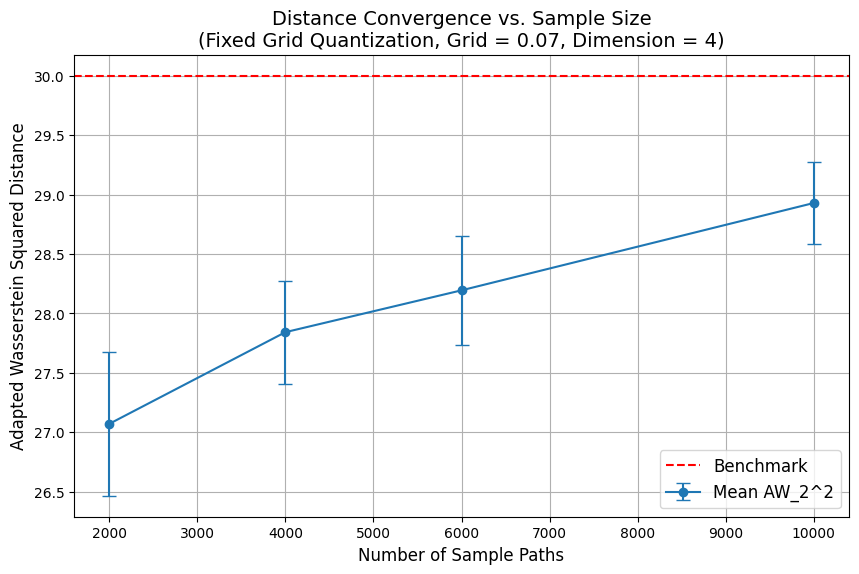

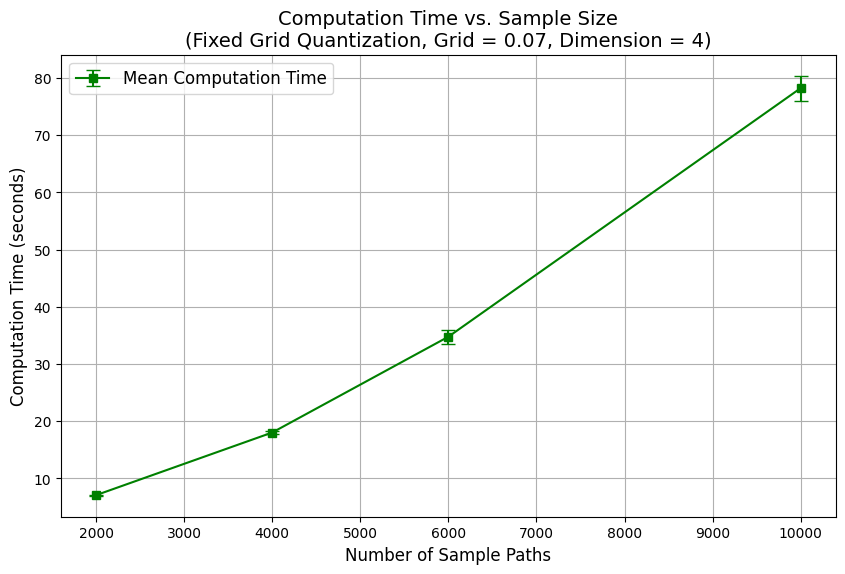

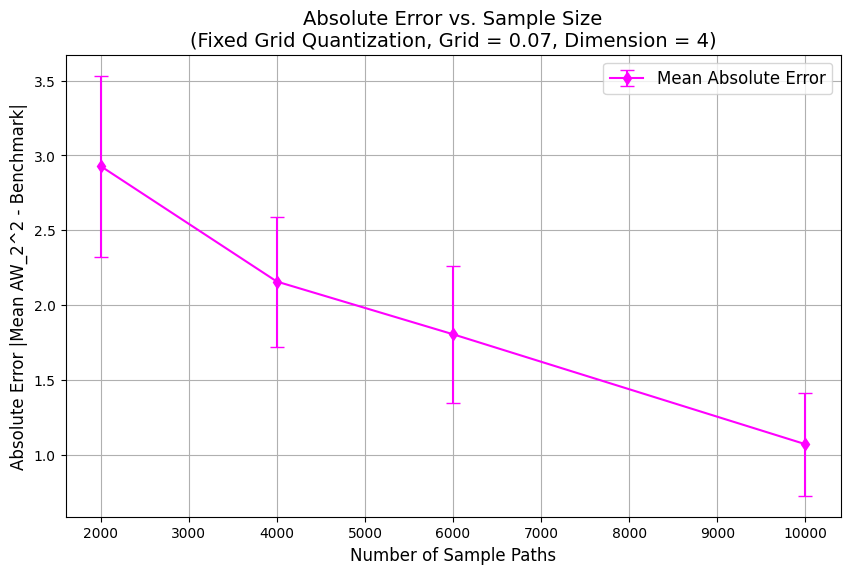

In [15]:
sample_list = sorted(aggregated.keys())
mean_distances = [aggregated[n]["mean_distance"] for n in sample_list]
std_distances = [aggregated[n]["std_distance"] for n in sample_list]
mean_times = [aggregated[n]["mean_time"] for n in sample_list]
std_times = [aggregated[n]["std_time"] for n in sample_list]
mean_abs_errors = [aggregated[n]["mean_abs_error"] for n in sample_list]
std_abs_errors = [aggregated[n]["std_abs_error"] for n in sample_list]
benchmark = aggregated[sample_list[0]]["benchmark"]  # assuming benchmark is the same across sizes

# Plot 1: Distance Convergence
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.axhline(y=benchmark, color="red", linestyle="--", label="Benchmark")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Adapted Wasserstein Squared Distance", fontsize=12)
plt.title("Distance Convergence vs. Sample Size\n(Fixed Grid Quantization, Grid = 0.07, Dimension = 4)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 2: Computation Time
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Computation Time (seconds)", fontsize=12)
plt.title("Computation Time vs. Sample Size\n(Fixed Grid Quantization, Grid = 0.07, Dimension = 4)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 3: Absolute Error
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_abs_errors, yerr=std_abs_errors, fmt="d-", capsize=5, color="magenta", label="Mean Absolute Error")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Absolute Error |Mean AW_2^2 - Benchmark|", fontsize=12)
plt.title("Absolute Error vs. Sample Size\n(Fixed Grid Quantization, Grid = 0.07, Dimension = 4)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()